# Tutorial introduction to PyDEC
Python library for DEC and lowest order FEEC

Anil Hirani and Kaushik Kalyanaraman

---

## Meshes

In [8]:
import numpy as np

Let's start with creating a small mesh from scratch of a square by giving the vertex locations and the connectivity of the vertices.

In [9]:
# Create small mesh of square
from pydec import simplicial_complex

vertices = np.array(
       [[-0.5 , -0.5 ],
       [-0.5 ,  0.5 ],
       [-0.04,  0.2 ],
       [ 0.  , -0.5 ],
       [ 0.  ,  0.5 ],
       [ 0.04,  0.2 ],
       [ 0.5 , -0.5 ],
       [ 0.5 ,  0.5 ]])
triangles = np.array([[0, 2, 1],[0, 3, 2],[1, 2, 4],
                      [2, 3, 5],[2, 5, 4],[3, 6, 5],
                      [4, 5, 7],[5, 6, 7]], dtype=int)
sc = simplicial_complex((vertices, triangles))

Now draw the mesh created above using `matplotlib`

(np.float64(-0.55), np.float64(0.55), np.float64(-0.55), np.float64(0.55))

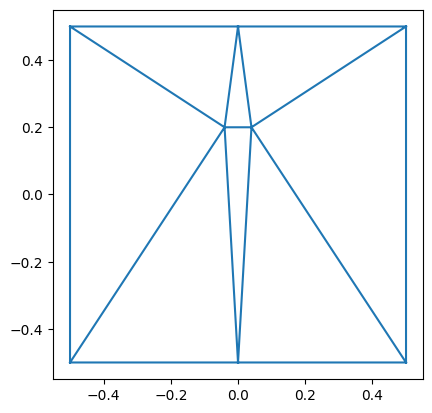

In [7]:
# Draw mesh using matplotlib
import matplotlib.pyplot as plt

plt.triplot(vertices[:, 0], vertices[:, 1], triangles)
plt.axis('square')

As an alternate method for drawing the mesh we can use our `visualizable_simplicial_mesh` included as a module with this tutorial. (This is not part of standard PyDEC distribution).

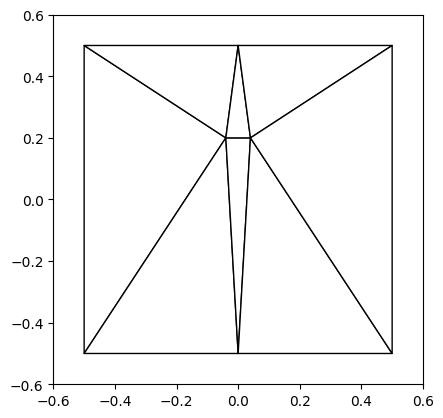

In [10]:
# Draw mesh using visualizable simplicial mesh
from vismesh import visualizable_simplicial_mesh

vm = visualizable_simplicial_mesh((vertices, triangles))
vm.draw()

This has some features helpful in debugging. For example, we can examing the numbering for all the simplices. This is useful for smallish meshes.

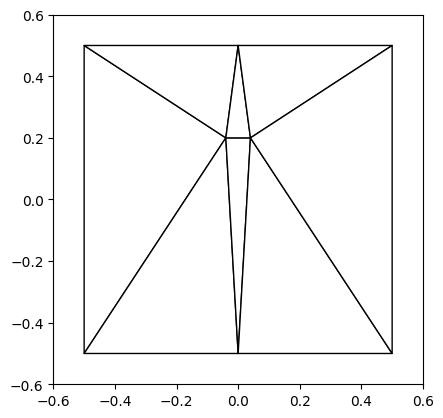

In [18]:
# Display simplex numbers

vm.draw()
vm.display_indices()

There is a system for orienting the top dimensional simplices (triangles here) and lower dimensional simplices (edges). These are specified using the vertex ordering.

Meshes can also be loaded from various types of files. Here is an example if using text files included with this tutorial.

In [8]:
# Load larger mesh of square and draw it using `visualizable_simplicial_mesh`


In [9]:
# Load mesh of annulus and draw it.

---

## Discrete exterior derivatives

The discrete exterior derivatives are the coboundary operators. There are 3 for a mesh in two dimensions" the d0, d1, and d2. The matrix representation for these for the small square mesh are printed below.

In [10]:
# d0, d1, d2

Note the complex property: $d_1 d_0 = 0$ using matrix multiplication

In [11]:
# Complex property

---

## Hodge star

The DEC Hodge star matrices are diagonal matrices with all positive entries. The values are dual over primal measure. There is one matrix for each dimension (0,1,2).

In [12]:
# Hodge star 0, 1, 2 matrices

DEC does not save an explicit representation of the dual cell complex

---

## PDEs with Hodge-Laplacian

Now we will solve two different PDEs with Hodge-Laplace operator. This can be done in mixed form or direct form.

In [14]:
# Hodge-Laplace problem

In [15]:
# Helmholtz problem

---

## Connection with finite element exterior calculus

By replacing the diagonal DEC mass matrices with lowest order FEEC mass matrices the above setup becomes a finite element method.

In [16]:
# FEEC version of Hodge-Laplace problem

Whitney forms allow one to visualize the solutions computed as a vector field.

In [17]:
# Visualize the FEEC Hodge-Laplace solution for k=1

In [18]:
# Visualize the DEC Hodge-Laplace solution for k=1

---

## Working with graphs

Abstract simplicial complexes in PyDEC allows working with graphs and graph Laplacians.

In [19]:
# Create a simple graph

The graph Laplacian is $d_0^T d_0$

In [20]:
# Print d_0 and the graph Laplacian